## Imports

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import make_scorer, fbeta_score

from skopt import BayesSearchCV

import shap

import warnings
warnings.filterwarnings("ignore")

## Read Dataset

In [17]:
data = pd.read_csv("data/Heart_Disease_Kaggle_Preprocessed.csv")
print(data.shape)
data.head()

(268, 14)


,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,ECG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,1.733026,0.681528,0.871534,-0.064103,1.407389,-0.418854,0.977857,-1.777056,-0.699206,1.193857,0.680101,2.462874,-0.881493,1
1,1.400801,-1.467290,-0.180588,-0.914581,6.109512,-0.418854,0.977857,0.437459,-0.699206,0.491048,0.680101,-0.715538,1.181740,0
2,0.293383,0.681528,-1.232710,-0.404294,0.222143,-0.418854,-1.022644,-0.387556,-0.699206,-0.651016,-0.947283,-0.715538,1.181740,1
3,1.068576,0.681528,0.871534,-0.177500,0.261004,-0.418854,-1.022644,-1.950743,1.430194,-0.738867,0.680101,0.343933,1.181740,0
4,2.175994,-1.467290,-1.232710,-0.631088,0.377585,-0.418854,0.977857,-1.255994,1.430194,-0.738867,-0.947283,0.343933,-0.881493,0


## Data split

In [18]:
X = data.drop(columns=["Heart Disease"])
y = data["Heart Disease"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Metrics settings

In [19]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fbeta_scorer = make_scorer(fbeta_score, beta=2)

scoring_metrics = {
    "accuracy": "accuracy",
    "precision": "precision",
    "recall": "recall",
    "fbeta_2": fbeta_scorer,
    "roc_auc": "roc_auc"
}

## Cross-validation

In [20]:
rf = RandomForestClassifier()
scores_rf = cross_validate(rf, X, y, cv=cv, scoring=scoring_metrics)

print("Scores Random Forest:")
for metric in scoring_metrics:
    mean_score = np.mean(scores_rf[f"test_{metric}"])
    std_score = np.std(scores_rf[f"test_{metric}"])
    print(f"{metric.capitalize()}: {mean_score:.4f} ± {std_score:.4f}")


Scores Random Forest:
Accuracy: 0.8357 ± 0.0827
Precision: 0.8421 ± 0.1013
Recall: 0.7826 ± 0.1091
Fbeta_2: 0.7922 ± 0.1029
Roc_auc: 0.9067 ± 0.0663


## Bayesian Optimization

In [21]:
search_space = {
    'n_estimators': (10, 500),  # Number of trees
    'max_depth': (1, 50),  # Maximum depth of each tree
    'min_samples_split': (2, 20),  # Minimum samples required to split an internal node
    'min_samples_leaf': (1, 20),  # Minimum samples required at a leaf node
    'max_features': ['sqrt', 'log2', None],  # Max features to consider for each split
    'bootstrap': [True, False]  # Whether bootstrap samples are used when building trees
}

opt_rf = BayesSearchCV(
    RandomForestClassifier(random_state=42),
    search_spaces=search_space,
    scoring="roc_auc",  # Use ROC AUC directly
    cv=cv,
    n_iter=30,  # Number of iterations for the search
    n_jobs=-1,  # Use all available CPUs
    random_state=42
)

# Fit the model
opt_rf.fit(X, y)

best_params = opt_rf.best_params_

# Print the best parameters and the best ROC-AUC score
print("Best parameters:", best_params)
print("Best ROC AUC score (cv):", opt_rf.best_score_)

Best parameters: OrderedDict([('bootstrap', False), ('max_depth', 39), ('max_features', 'log2'), ('min_samples_leaf', 18), ('min_samples_split', 13), ('n_estimators', 301)])
Best ROC AUC score (cv): 0.9181679993336666


## Cross-validation with best model

In [22]:
rf = RandomForestClassifier(**best_params)
scores_rf = cross_validate(rf, X, y, cv=cv, scoring=scoring_metrics)

print("Scores Random Forest:")
for metric in scoring_metrics:
    mean_score = np.mean(scores_rf[f"test_{metric}"])
    std_score = np.std(scores_rf[f"test_{metric}"])
    print(f"{metric.capitalize()}: {mean_score:.4f} ± {std_score:.4f}")


Scores Random Forest:
Accuracy: 0.8617 ± 0.0926
Precision: 0.8904 ± 0.0971
Recall: 0.7826 ± 0.1372
Fbeta_2: 0.8007 ± 0.1303
Roc_auc: 0.9162 ± 0.0683


## Feature Importance | SHAP

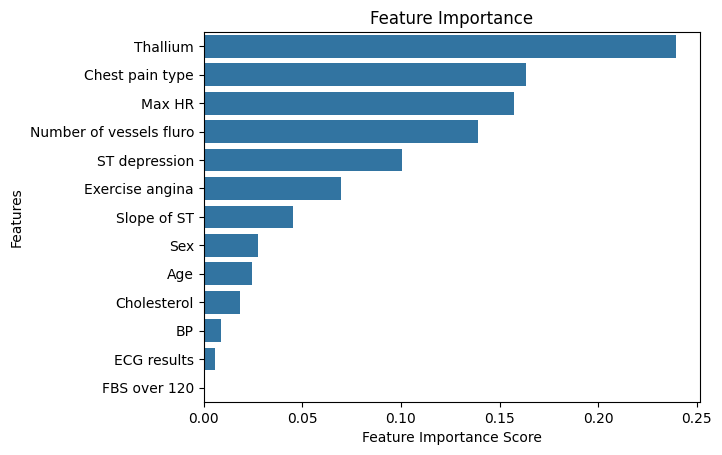

In [23]:
rf.fit(X_train, y_train)

feature_importance = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

# Plotting Feature Importance
sns.barplot(x=feature_importance, y=feature_importance.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.show()